<a href="https://colab.research.google.com/github/ASADUZZAMAN-HEROK/Frequent-Pattern-Mining-Algorithm/blob/main/Apriori_Vs_FP_Growth_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Task: 
###Analysis of runtime of Apriori and Frequent Pattern Growth Algorithm \
\
\
Author:\
Asaduzzaman Herok\
ID: 170041034\
Computer Science and Engineering\
Islamic University Technology

In [59]:
!pip install kaggle

import os
import zipfile
import pandas as pd
import time

from matplotlib import pyplot as plt
from itertools import chain, combinations
from IPython.display import clear_output
clear_output()

In [60]:
#Upload Kaggle API token. File name must be kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"asaduzzamanherok","key":"fc4edcbb4c4d097d355301c0b01d3952"}'}

In [61]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [62]:
#Dataset The Bread Basket
!kaggle datasets download -d mittalvasu95/the-bread-basket
!unzip /content/the-bread-basket.zip

the-bread-basket.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/the-bread-basket.zip
replace bread basket.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bread basket.csv        


In [63]:
#Dataset The Bread Basket
!kaggle datasets download -d rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba
!unzip /content/groceries-dataset-for-market-basket-analysismba.zip

groceries-dataset-for-market-basket-analysismba.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/groceries-dataset-for-market-basket-analysismba.zip
replace Groceries data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Groceries data.csv      
replace basket.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: basket.csv              


In [64]:
#Data Load
bread_basket = pd.DataFrame(pd.read_csv('/content/bread basket.csv'))
market_basket = pd.DataFrame(pd.read_csv('/content/basket.csv'))
print(bread_basket.head())
print(market_basket.head())

   Transaction           Item         date_time period_day weekday_weekend
0            1          Bread  30-10-2016 09:58    morning         weekend
1            2   Scandinavian  30-10-2016 10:05    morning         weekend
2            2   Scandinavian  30-10-2016 10:05    morning         weekend
3            3  Hot chocolate  30-10-2016 10:07    morning         weekend
4            3            Jam  30-10-2016 10:07    morning         weekend
             0                   1                    2  ...    8    9   10
0   whole milk              pastry          salty snack  ...  NaN  NaN  NaN
1      sausage          whole milk  semi-finished bread  ...  NaN  NaN  NaN
2         soda  pickled vegetables                  NaN  ...  NaN  NaN  NaN
3  canned beer     misc. beverages                  NaN  ...  NaN  NaN  NaN
4      sausage    hygiene articles                  NaN  ...  NaN  NaN  NaN

[5 rows x 11 columns]


In [65]:
#Preprocess Bread Basket
bread_basket = bread_basket.fillna(0)
market_basket = market_basket.fillna(0)
bread_transactions = dict()

for idx in bread_basket.index:
  if bread_transactions.get(bread_basket['Transaction'][idx])==None:
    bread_transactions[bread_basket['Transaction'][idx]]=set()
  bread_transactions[bread_basket['Transaction'][idx]].add(bread_basket['Item'][idx])

market_transactions = dict()
for idx in market_basket.index:
  market_transactions[idx]=set()
  for col in market_basket.columns:
    market_transactions[idx].add(market_basket[col][idx])
  market_transactions[idx].discard(0)


In [66]:
## all Possible Combination
def generate_subsets(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1)))


In [67]:
#################### Frequent Pattern Growth Algorithm ################
class Node:
  def __init__(self, item):
    self.item = item
    self.branch = dict()
    self.frequency = 0
  def addBranch(self, node):
    if node == None:
      return
    self.branch[node.item]=node

class FP_Growth:
  def __init__(self, transactions: dict, min_sup = 2):
    self.transactions = transactions.copy()
    self.runTime = 0
    self.uniqe_items = set()
    self.supportCount = dict()
    self.root = Node('NULL')
    self.min_sup = min_sup
    self.conditionalPatterBase = dict()
    self.conditionalFPTree = dict()
    self.frequentPatterns = dict()

  def __generateSupportCount__(self):
    for itemSet in self.transactions.values():
      for item in itemSet:
        if self.supportCount.get(item)==None:
          self.supportCount[item]=0
        self.supportCount[item]+=1
    self.supportCount = dict(sorted(list(self.supportCount.items()), key = lambda item: (-1*item[1],item)))
  

  def __sortitemSets__(self):
    for key in self.transactions.keys():
      itemSet = self.transactions[key]
      itemSet = sorted(itemSet, key= lambda item: (-1*self.supportCount[item],item))
      self.transactions[key] = itemSet
  
  def __generateUniqeItemList__(self):
    for itemSet in self.transactions.values():
      for item in itemSet:
        self.uniqe_items.add(item)
    self.uniqe_items = set(sorted(self.uniqe_items))

  def __addItemSetToTree__(self, nextNode, itemSet):
    nextNode.frequency+=1
    if len(itemSet)==0:
      return nextNode
    item = itemSet.pop(0)
   # print(item)
    if nextNode.branch.get(item)==None:
      nextNode.addBranch(self.__addItemSetToTree__(Node(item),itemSet))
    else:
      nextNode.addBranch(self.__addItemSetToTree__(nextNode.branch[item],itemSet))
    #print("[Ret]", nextNode.branch)
    return nextNode


  def __buildTree__(self):
    self.__generateSupportCount__()
    self.__sortitemSets__()
    for itemSet in self.transactions.values():
      self.root = self.__addItemSetToTree__( self.root, itemSet.copy())
  

  def showTreeTravers(self, node):
    if(node == None):
      return
    print("Enter",node.item,node.frequency)
    for next in node.branch.keys():
      self.showTreeTravers(node.branch[next])
    print("exit", node.item, node.frequency)
  
  def __generatePattern__(self, path, node):
    if node == None:
      return
    for next in node.branch.keys():
      newPath = path.copy()
      newPath.append(next)
      self.__generatePattern__(newPath.copy(),node.branch[next])
    if len(path) > 0:
      path.pop()
    if self.conditionalPatterBase.get(node.item)==None:
      self.conditionalPatterBase[node.item]=[]
    self.conditionalPatterBase[node.item].append((tuple(path.copy()),node.frequency))


  
  def __generateConditionalFPTree__(self):
    for item, frqPat in list(self.conditionalPatterBase.items()):
      prefix = dict()
      occurence = dict()
      sortedFrqPat = sorted(list(frqPat))
      sortedFrqPat.append(('!!##',0))
      #print(item, sortedFrqPat)
      for idx in range(len(sortedFrqPat)-1):
        pat, frq = sortedFrqPat[idx]
        nextPat, nextFrq = sortedFrqPat[idx+1]

        for it in pat:
          if occurence.get(it)==None:
            occurence[it]=0
          occurence[it]+=frq
        if len(pat) > len(nextPat) or (len(pat) <= len(nextPat) and pat != nextPat[:len(pat)]):
          prefix[pat]=occurence.copy()
         # print(pat)
          occurence = dict()

      for x in prefix.values():

        if self.conditionalFPTree.get(item)==None:
          self.conditionalFPTree[item]=[]
        self.conditionalFPTree[item].append(list(x.items()))

  def generateFrequentPatterns(self):
    self.__init__(self.transactions,self.min_sup)
    self.frequentPatterns = dict()
    startTime = time.time()
    self.__generateUniqeItemList__()
    self.__buildTree__()
    self.__generatePattern__([],fp.root)
    self.__generateConditionalFPTree__()
    for item, fpTree in self.conditionalFPTree.items():
      
      for itemset in fpTree:
        allSubSet = generate_subsets(itemset)
        
        for subset in allSubSet:
          frqSet = []
          mnFrq = 1e18
          for it,frq in subset:
            mnFrq = min(mnFrq,frq)
            frqSet.append(it)
          frqSet.append(item)
          frqSet = sorted(frqSet)
          
          if self.frequentPatterns.get(tuple(frqSet))==None:
            self.frequentPatterns[tuple(frqSet)]=0
          self.frequentPatterns[tuple(frqSet)]+=mnFrq
    fqPat = list(self.frequentPatterns.keys())
    for pat in fqPat:
      if self.frequentPatterns[pat]<self.min_sup:
        del self.frequentPatterns[pat]
    
    patternSet = set()
    for item in self.frequentPatterns.items():
      patternSet.add(item)
    self.frequentPatterns = sorted(patternSet)
    self.runTime+=time.time()-startTime

In [68]:
#########################  Apriori Algorithm #################

class Apriori:
  def __init__(self, transactions: dict, min_sup = 2):
    self.transactions = transactions.copy()
    self.runTime = 0
    self.min_sup = min_sup
    self.levels = []
    self.uniqe_items = set()
    self.frequentPatterns = set()
    self.__generateUniqeItemList__()
  
  def __generateSupportCount__(self, candidates: set):
    newDict=dict()
    for itemSet in self.transactions.values():
      for candidate in candidates:
        isFound = True
        for item in candidate:
          isFound = isFound and item in itemSet 
        if isFound == True:
          if newDict.get(candidate) == None:
            newDict[candidate]=0
          newDict[candidate]+=1
    self.levels.append(newDict)

  def __pruningByMinSupCount__(self, lvl: int):
    itemSets = list(self.levels[lvl].keys())
    for itemSet in itemSets:
      if self.levels[lvl][itemSet] < self.min_sup:
        del self.levels[lvl][itemSet]
  
  def __generateUniqeItemList__(self):
    for itemSet in self.transactions.values():
      for item in itemSet:
        self.uniqe_items.add(item)
    self.uniqe_items = set(sorted(self.uniqe_items))
  
  def __cross__(self, lvl:int):
    candidateList = set()
    for itemSet in self.levels[lvl].keys():
      for itemSet2 in self.levels[lvl].keys():
        tempSet = set([x for x in itemSet])
        tempSet.update([x for x in itemSet2])
        tempSet = sorted(tempSet)
        if len(tempSet) == len(itemSet)+1:
          candidateList.add(tuple(tempSet))
    return candidateList.copy()
  
  def __buildLevels__(self):
    startTime = time.time()
    candidateList = set((x,) for x in self.uniqe_items)
    self.__generateSupportCount__(candidateList.copy())
    self.__pruningByMinSupCount__(0)

    while len(self.levels[-1]) > 0:
      candidateList = self.__cross__(len(self.levels)-1)
      self.__generateSupportCount__(candidateList.copy())
      self.__pruningByMinSupCount__(len(self.levels)-1)

    self.runTime+=time.time()-startTime
  
  def generateFrequentPatterns(self):
    self.__init__(self.transactions,self.min_sup)
    self.__buildLevels__()
    for d in self.levels[1:]:
      for item in d.items():
        self.frequentPatterns.add((item[0],item[1]))
    self.frequentPatterns = sorted(self.frequentPatterns)
  


In [69]:
#################### Test Set ####################
test_transactions =dict( [(1,{'I1','I2','I5'}),\
                     (2,{'I2','I4'}),\
                     (3,{'I2','I3'}),\
                     (4,{'I1','I2','I4'}),\
                     (5,{'I1','I3'}),\
                     (6,{'I2','I3'}),\
                     (7,{'I1','I3'}),\
                     (8,{'I2','I1','I3','I5'}),\
                     (9,{'I1','I2','I3'})])

test_transactions_2 = dict([(1, {'A','B'}),\
                            (2, {'B','C','D'}),\
                            (3, {'A','C','D','E'}),\
                            (4, {'A','D','E'}),\
                            (5, {'A','B','C'}),\
                            (6, {'A','B','C','D'}),\
                            (7, {'A'}),\
                            (8, {'A','B','C'}),\
                            (9, {'A','B','D'}),\
                            (10, {'B','C','E'})])


ap = Apriori(test_transactions, min_sup=2)
fp = FP_Growth(test_transactions,min_sup=2)

fp.generateFrequentPatterns()
print(fp.supportCount)
print(fp.conditionalPatterBase)
print(fp.conditionalFPTree)
fp.showTreeTravers(fp.root)
ap.generateFrequentPatterns()


# print("Items in Apriori  : ", ap.uniqe_items)
# print("Items in FP_Growth: ", fp.uniqe_items)

# print("Runtime in Apriori  :", ap.runTime)
# print("Runtime in FP_Growth:", fp.runTime)

print("Frequent Patterns by Apriori:")
for pat in ap.frequentPatterns:
  print(pat)

print("Frequent Patterns by FP_Growth:")
for pat in fp.frequentPatterns:
  print(pat)

{'I2': 7, 'I1': 6, 'I3': 6, 'I4': 2, 'I5': 2}
{'I5': [(('I2', 'I1'), 1), (('I2', 'I1', 'I3'), 1)], 'I4': [(('I2', 'I1'), 1), (('I2',), 1)], 'I3': [(('I2', 'I1'), 2), (('I2',), 2), (('I1',), 2)], 'I1': [(('I2',), 4), ((), 2)], 'I2': [((), 7)], 'NULL': [((), 9)]}
{'I5': [[('I2', 2), ('I1', 2), ('I3', 1)]], 'I4': [[('I2', 2), ('I1', 1)]], 'I3': [[('I1', 2)], [('I2', 4), ('I1', 2)]], 'I1': [[('I2', 4)]], 'I2': [[]], 'NULL': [[]]}
Enter NULL 9
Enter I2 7
Enter I1 4
Enter I5 1
exit I5 1
Enter I4 1
exit I4 1
Enter I3 2
Enter I5 1
exit I5 1
exit I3 2
exit I1 4
Enter I4 1
exit I4 1
Enter I3 2
exit I3 2
exit I2 7
Enter I1 2
Enter I3 2
exit I3 2
exit I1 2
exit NULL 9
Frequent Patterns by Apriori:
(('I1', 'I2'), 4)
(('I1', 'I2', 'I3'), 2)
(('I1', 'I2', 'I5'), 2)
(('I1', 'I3'), 4)
(('I1', 'I5'), 2)
(('I2', 'I3'), 4)
(('I2', 'I4'), 2)
(('I2', 'I5'), 2)
Frequent Patterns by FP_Growth:
(('I1', 'I2'), 4)
(('I1', 'I2', 'I3'), 2)
(('I1', 'I2', 'I5'), 2)
(('I1', 'I3'), 4)
(('I1', 'I5'), 2)
(('I2', 'I3'), 

In [70]:
################ Test on Bread_Basket ######################
ap = Apriori(bread_transactions, min_sup=50)
fp = FP_Growth(bread_transactions,min_sup=50)

fp.generateFrequentPatterns()
ap.generateFrequentPatterns()

print("Items in Apriori  : ", ap.uniqe_items)
print("Items in FP_Growth: ", fp.uniqe_items)

print("")

print("Runtime in Apriori  :", ap.runTime)
print("Runtime in FP_Growth:", fp.runTime)

print("")

print("Are the  generated frequent patterns same: ", ap.frequentPatterns==fp.frequentPatterns)

print("Frequent Patterns by Apriori:")
for pat in ap.frequentPatterns:
  print(pat)

print("")


Items in Apriori  :  {'Toast', 'Spanish Brunch', 'Raspberry shortbread sandwich', 'Victorian Sponge', "Ella's Kitchen Pouches", 'Scandinavian', 'Tartine', 'Olum & polenta', 'Adjustment', 'Bowl Nic Pitt', 'Muesli', 'Empanadas', 'Bread Pudding', 'Hack the stack', 'Honey', 'Dulce de Leche', 'Brioche and salami', 'Art Tray', 'Pick and Mix Bowls', 'Drinking chocolate spoons ', 'Smoothies', 'Extra Salami or Feta', 'Polenta', 'Crisps', 'Focaccia', 'Alfajores', 'Soup', 'Afternoon with the baker', 'Chicken sand', 'Truffles', 'Panatone', 'Argentina Night', 'Lemon and coconut', 'Crepes', 'Muffin', 'Pintxos', 'Coffee granules ', 'Gingerbread syrup', 'Cherry me Dried fruit', 'Farm House', 'Hearty & Seasonal', 'Tacos/Fajita', 'Medialuna', 'Bacon', 'Coffee', 'Vegan mincepie', 'Brownie', 'Frittata', 'Bakewell', 'Tiffin', 'Duck egg', 'Nomad bag', 'Chicken Stew', 'Mortimer', 'Mineral water', 'Raw bars', "Valentine's card", 'Postcard', 'Granola', 'Chocolates', 'Basket', 'Salad', 'The Nomad', 'Baguette', 

In [71]:
################ Test on Market_Basket ######################
ap = Apriori(market_transactions, min_sup=50)
fp = FP_Growth(market_transactions,min_sup=50)

fp.generateFrequentPatterns()
ap.generateFrequentPatterns()

print("Items in Apriori  : ", ap.uniqe_items)
print("Items in FP_Growth: ", fp.uniqe_items)

print("")

print("Runtime in Apriori  :", ap.runTime)
print("Runtime in FP_Growth:", fp.runTime)

print("")
print("Are the  generated frequent patterns same: ", ap.frequentPatterns==fp.frequentPatterns)

print("Frequent Patterns by Apriori:")
for pat in ap.frequentPatterns:
  print(pat)

print("")


Items in Apriori  :  {'nut snack', 'napkins', 'syrup', 'dental care', 'specialty cheese', 'popcorn', 'pasta', 'frankfurter', 'white wine', 'hygiene articles', 'specialty fat', 'baking powder', 'cleaner', 'processed cheese', 'hair spray', 'berries', 'abrasive cleaner', 'misc. beverages', 'skin care', 'chocolate', 'sauces', 'spices', 'fruit/vegetable juice', 'male cosmetics', 'rice', 'sugar', 'flower (seeds)', 'yogurt', 'baby cosmetics', 'oil', 'citrus fruit', 'cream cheese ', 'ham', 'sliced cheese', 'curd cheese', 'grapes', 'canned fruit', 'cream', 'salt', 'mustard', 'root vegetables', 'potato products', 'candles', 'soups', 'canned beer', 'cocoa drinks', 'cat food', 'chewing gum', 'salty snack', 'cake bar', 'female sanitary products', 'packaged fruit/vegetables', 'ready soups', 'soft cheese', 'curd', 'frozen chicken', 'jam', 'hard cheese', 'rum', 'cling film/bags', 'coffee', 'preservation products', 'pet care', 'specialty chocolate', 'mayonnaise', 'chicken', 'pot plants', 'pudding powde

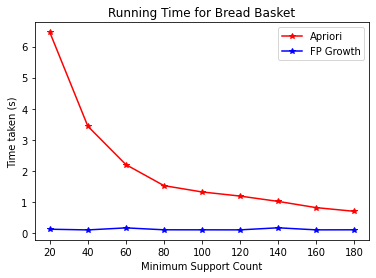

In [72]:
############### Run Time analysis ###################

## Bread Basket ##
ap = Apriori(bread_transactions)
fp = FP_Growth(bread_transactions)

timeTakenApriori=[]
timeTakenFPGrowth = []
min_sup_axis = []

for min_sup in range(20,200,20):
  fp.min_sup = min_sup
  ap.min_sup = min_sup
  fp.generateFrequentPatterns()
  ap.generateFrequentPatterns()
  min_sup_axis.append(min_sup)
  timeTakenFPGrowth.append(fp.runTime)
  timeTakenApriori.append(ap.runTime)

plt.plot(min_sup_axis,timeTakenApriori,'r-*', label = 'Apriori')
plt.plot(min_sup_axis,timeTakenFPGrowth, 'b-*', label = 'FP Growth')
plt.xlabel('Minimum Support Count')
plt.ylabel("Time taken (s)")
plt.legend()
plt.title('Running Time for Bread Basket')
plt.show()


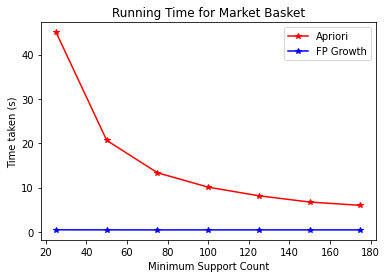

In [73]:
############### Run Time analysis ###################

## Market Basket ##
ap = Apriori(market_transactions)
fp = FP_Growth(market_transactions)

timeTakenApriori=[]
timeTakenFPGrowth = []
min_sup_axis = []

for min_sup in range(25,200,25):
  fp.min_sup = min_sup
  ap.min_sup = min_sup
  fp.generateFrequentPatterns()
  ap.generateFrequentPatterns()
  min_sup_axis.append(min_sup)
  timeTakenFPGrowth.append(fp.runTime)
  timeTakenApriori.append(ap.runTime)

plt.plot(min_sup_axis,timeTakenApriori,'r-*', label = 'Apriori')
plt.plot(min_sup_axis,timeTakenFPGrowth, 'b-*', label = 'FP Growth')
plt.xlabel('Minimum Support Count')
plt.ylabel("Time taken (s)")
plt.title('Running Time for Market Basket')
plt.legend()
plt.show()
